In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


bureau = "https://raw.githubusercontent.com/JY6299/CR_Modeling_2/refs/heads/main/bureau_data.csv"
loan = "https://raw.githubusercontent.com/JY6299/CR_Modeling_2/refs/heads/main/loans.csv"
cust = "https://raw.githubusercontent.com/JY6299/CR_Modeling_2/refs/heads/main/customers.csv"

bureau_data = pd.read_csv(bureau)
loan_data = pd.read_csv(loan)
cust_data = pd.read_csv(cust)

bureau_data.shape, loan_data.shape, cust_data.shape

((50000, 8), (50000, 15), (50000, 12))

In [2]:
#By Looking at the Data Structure, First to design the Segmentation

In [3]:
bureau_data.info(), loan_data.info(), cust_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   cust_id                    50000 non-null  object
 1   number_of_open_accounts    50000 non-null  int64 
 2   number_of_closed_accounts  50000 non-null  int64 
 3   total_loan_months          50000 non-null  int64 
 4   delinquent_months          50000 non-null  int64 
 5   total_dpd                  50000 non-null  int64 
 6   enquiry_count              50000 non-null  int64 
 7   credit_utilization_ratio   50000 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 3.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   loan_id                      50000 non-null  object 
 1   cust

(None, None, None)

In [4]:
#Drop some features that are apparantly meaningless data.
cust_data.drop(columns=['zipcode','state','city'],inplace=True)


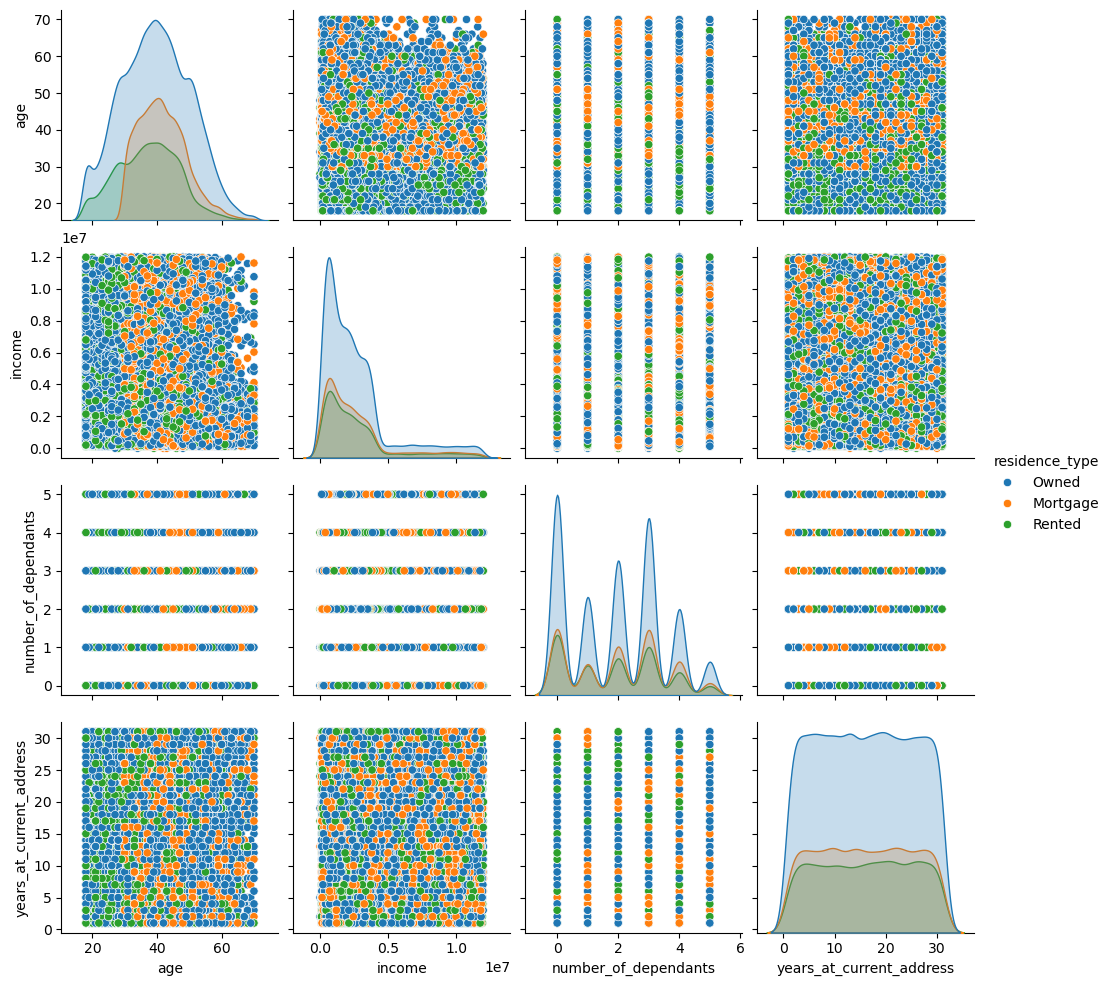

In [5]:
sns.pairplot(cust_data,hue='residence_type') #automatically skip char_var

#theres a significant pattern in age*year_at_current_address: younger people are more likely to rent

In [6]:
# Since we see missing value in residence_type, we fillna by age.
cust_data['residence_type'].value_counts()

cust_data.loc[
    (cust_data['age']<40) & (cust_data['residence_type'].isnull()), 'residence_type'
] = 'Rented'

cust_data.loc[
    (cust_data['age']>=40) & (cust_data['residence_type'].isnull()), 'residence_type'
] = 'Owned'


In [7]:
cust_data['residence_type'].value_counts()

residence_type
Owned       28267
Mortgage    11819
Rented       9914
Name: count, dtype: int64

In [8]:
cust_data.isnull().sum(),loan_data.isnull().sum(),bureau_data.isnull().sum()
#Now all datasets are clean and no missing values

(cust_id                     0
 age                         0
 gender                      0
 marital_status              0
 employment_status           0
 income                      0
 number_of_dependants        0
 residence_type              0
 years_at_current_address    0
 dtype: int64,
 loan_id                        0
 cust_id                        0
 loan_purpose                   0
 loan_type                      0
 sanction_amount                0
 loan_amount                    0
 processing_fee                 0
 gst                            0
 net_disbursement               0
 loan_tenure_months             0
 principal_outstanding          0
 bank_balance_at_application    0
 disbursal_date                 0
 installment_start_dt           0
 default                        0
 dtype: int64,
 cust_id                      0
 number_of_open_accounts      0
 number_of_closed_accounts    0
 total_loan_months            0
 delinquent_months            0
 total_dpd           

In [9]:
#Combine all datasets together based on acct level
df = pd.merge(cust_data,loan_data, how = 'left', on='cust_id')
df = pd.merge(df,bureau_data, how='left', on='cust_id')
df.shape


(50000, 30)

In [10]:
###### EDA, Explanatory Data Analysis ########

default
False    0.91406
True     0.08594
Name: proportion, dtype: float64


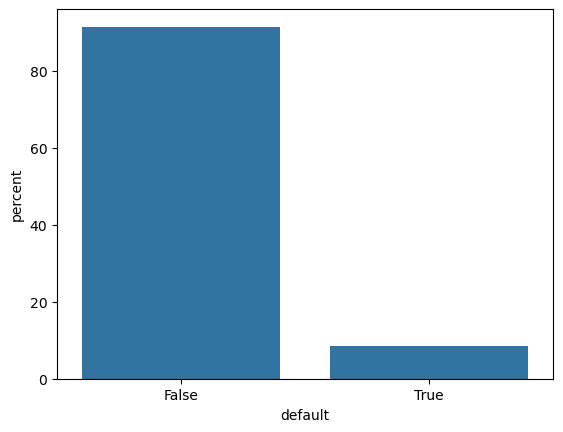

In [11]:
#first take a look at Response Variable, Default.

sns.countplot(data=df, x='default', stat='percent')
print(df['default'].value_counts(normalize=True))
# Default is extremly inbalanced, SMOTE to oversample defaulted(1) population

In [39]:
df[['disbursal_date','installment_start_dt']] = df[['disbursal_date','installment_start_dt']].apply(pd.to_datetime)

num_var = list(df.select_dtypes(include=['int64','float64']))
char_var = list(df.select_dtypes(include='object'))

char_var.remove('cust_id'),char_var.remove('loan_id')


for feature in char_var:
    print(f'{feature}: --->{df[feature].unique()}')

#For Loan_Purpose, we see "Personaal" spelling error
df['loan_purpose']=df['loan_purpose'].replace('Personaal','Personal')
df['loan_purpose'].unique()

gender: --->['M' 'F']
marital_status: --->['Married' 'Single']
employment_status: --->['Self-Employed' 'Salaried']
residence_type: --->['Owned' 'Mortgage' 'Rented']
loan_purpose: --->['Auto' 'Home' 'Personal' 'Education']
loan_type: --->['Secured' 'Unsecured']


array(['Auto', 'Home', 'Personal', 'Education'], dtype=object)

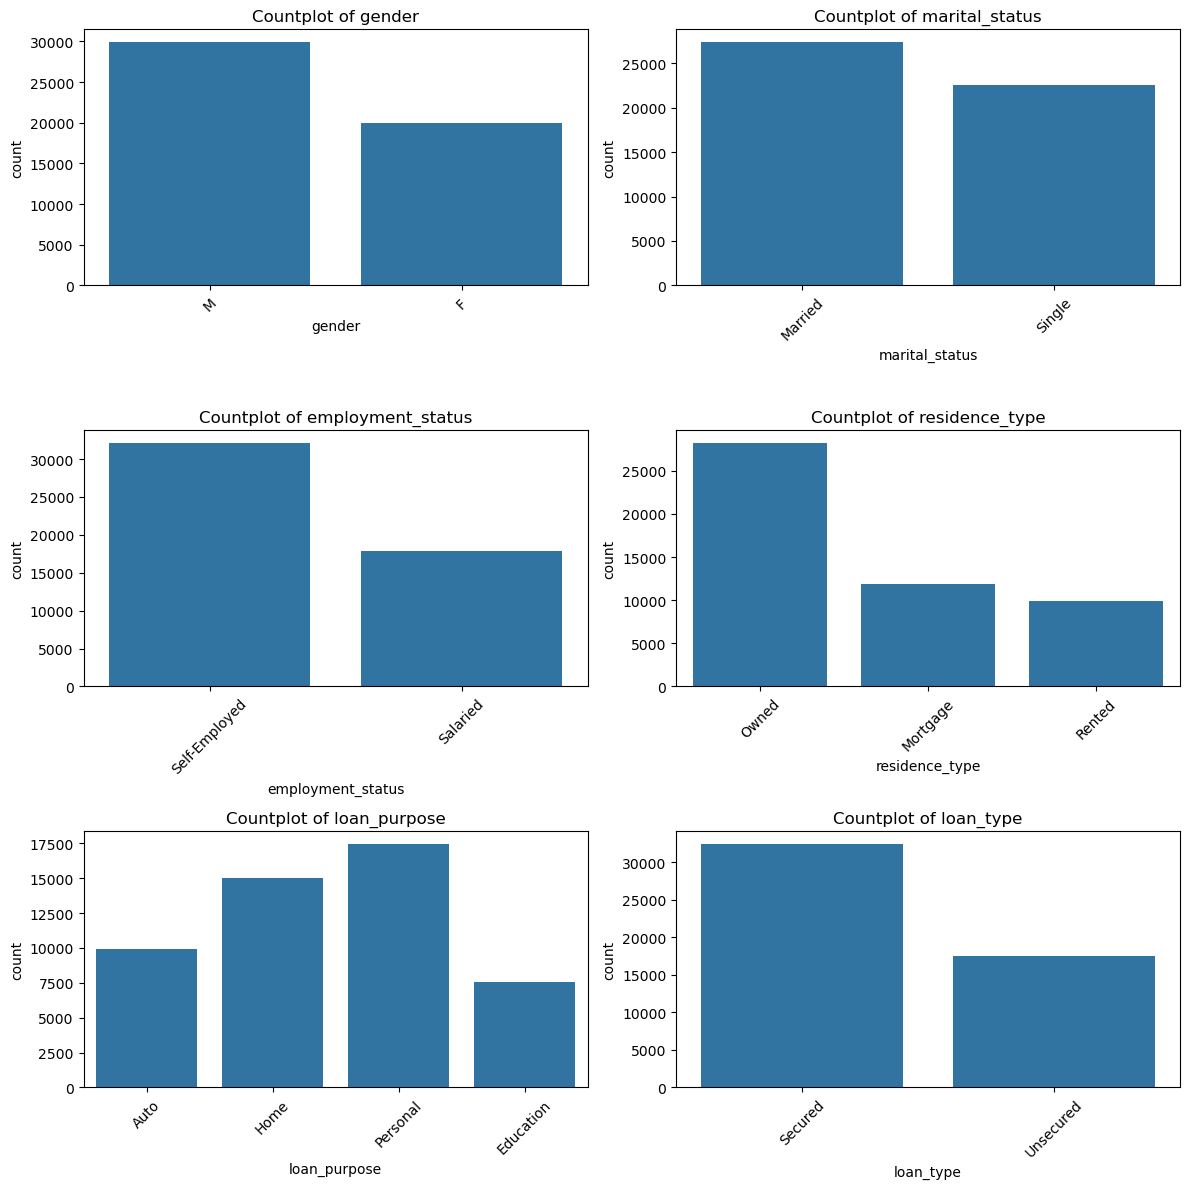

In [13]:
# Countplot for each character variable
n = len(char_var)
ncol = 2 # 2 subgraphs each row
nrow = (n+1) // 2 #round up

#Set subgraph layout dimension
fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(12,4*nrow))
axes = axes.flatten()

for i, feature in enumerate(char_var):
    sns.countplot(data=df, x=feature, ax=axes[i])
    axes[i].set_title(f'Countplot of {feature}')
    axes[i].tick_params(axis='x',rotation=45)

#Delete redundant subgraph not used.
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

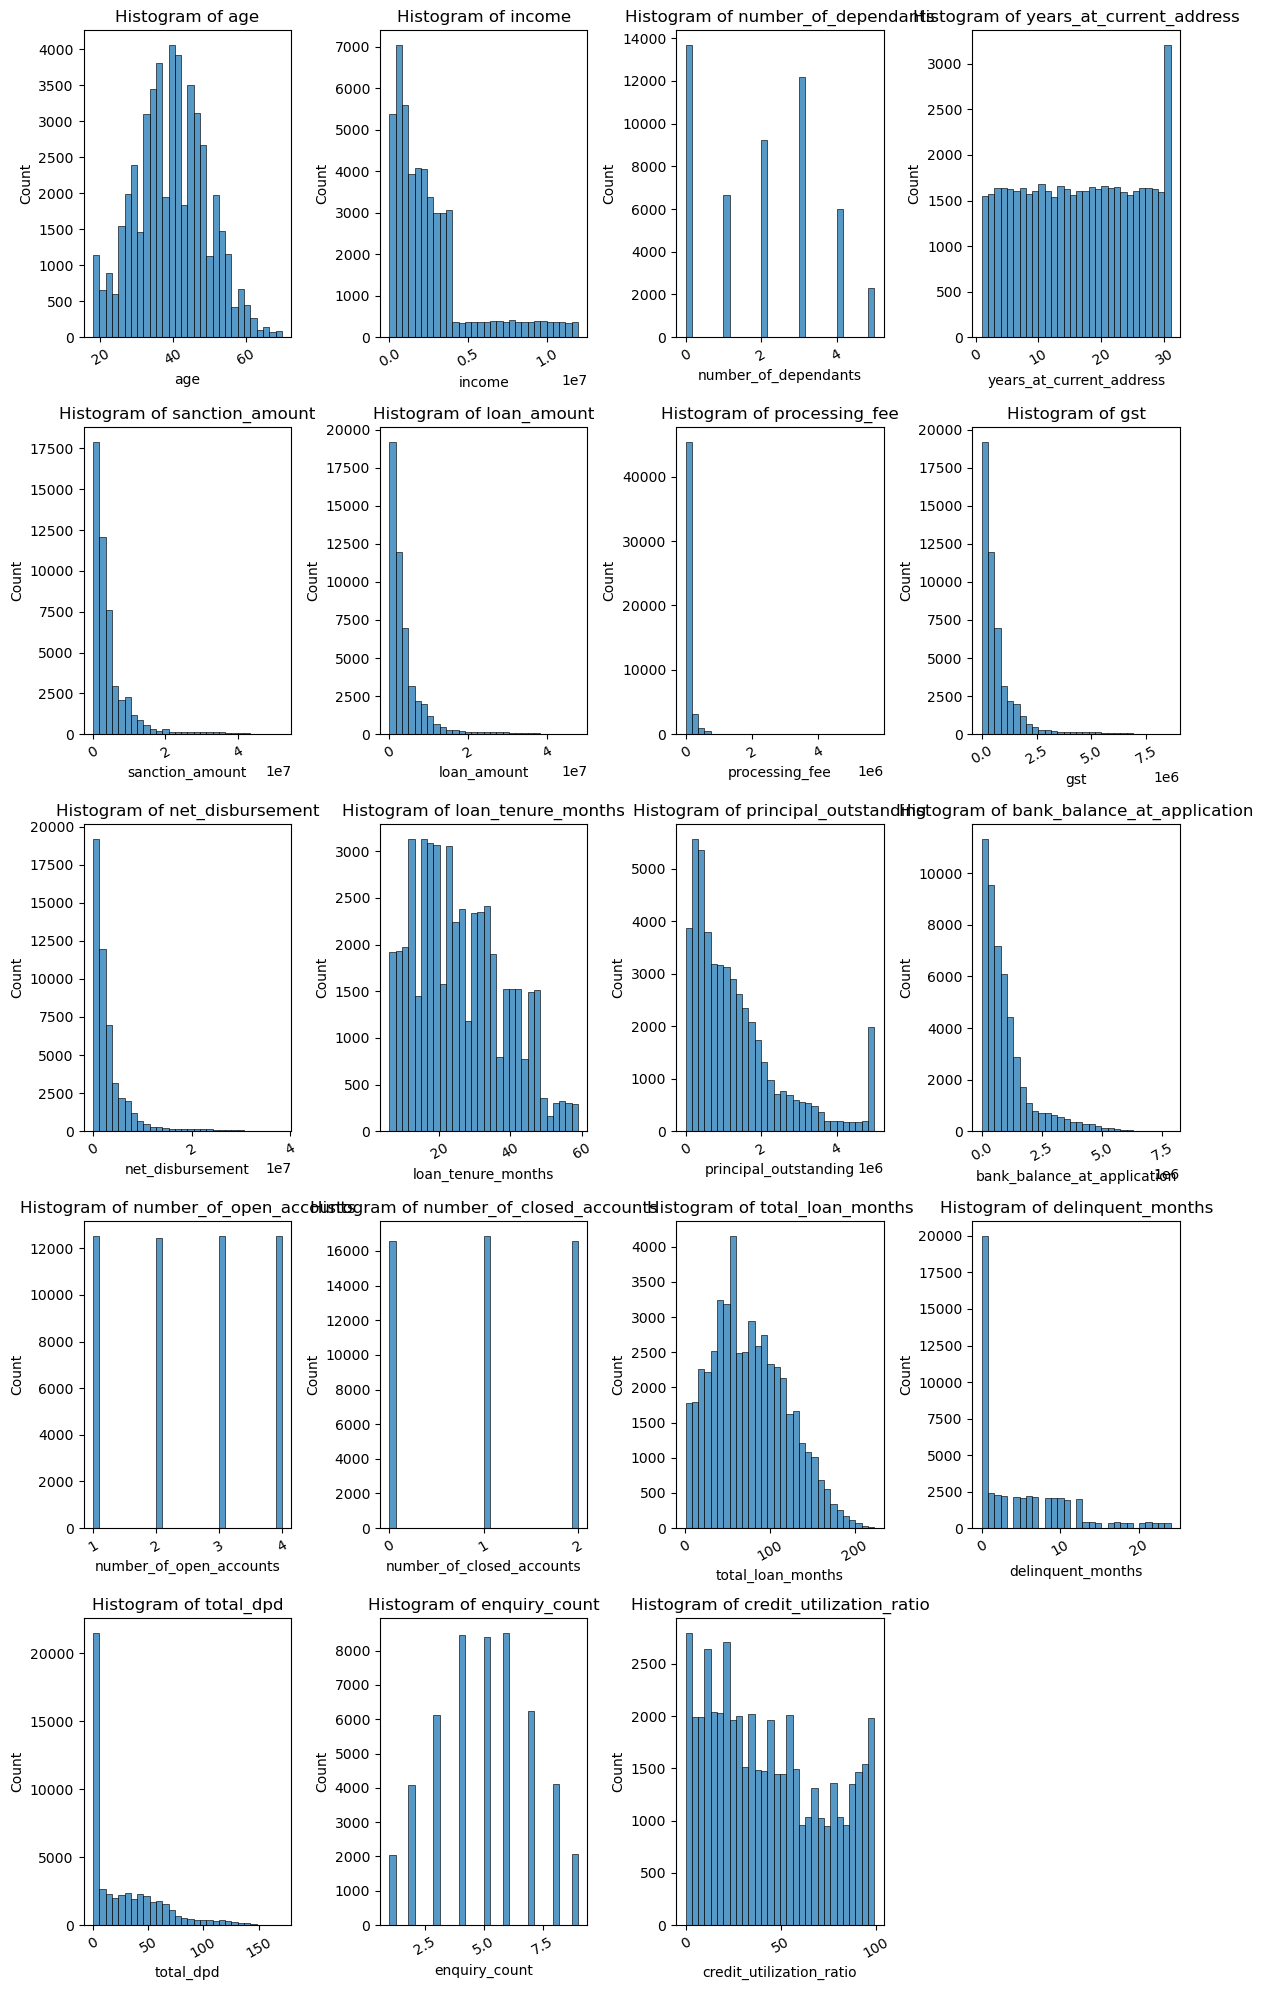

In [14]:
m = len(num_var)
ncols = 4
nrows = (m+ncols-1) // ncols

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(12,4*nrows))
axes = axes.flatten()

for i, var in enumerate(num_var):
  sns.histplot(data=df, x=var, ax=axes[i], bins=30, kde=False)
  axes[i].set_title(f"Histogram of {var}")
  axes[i].tick_params(axis='x', rotation=30)

for j in range(i+1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

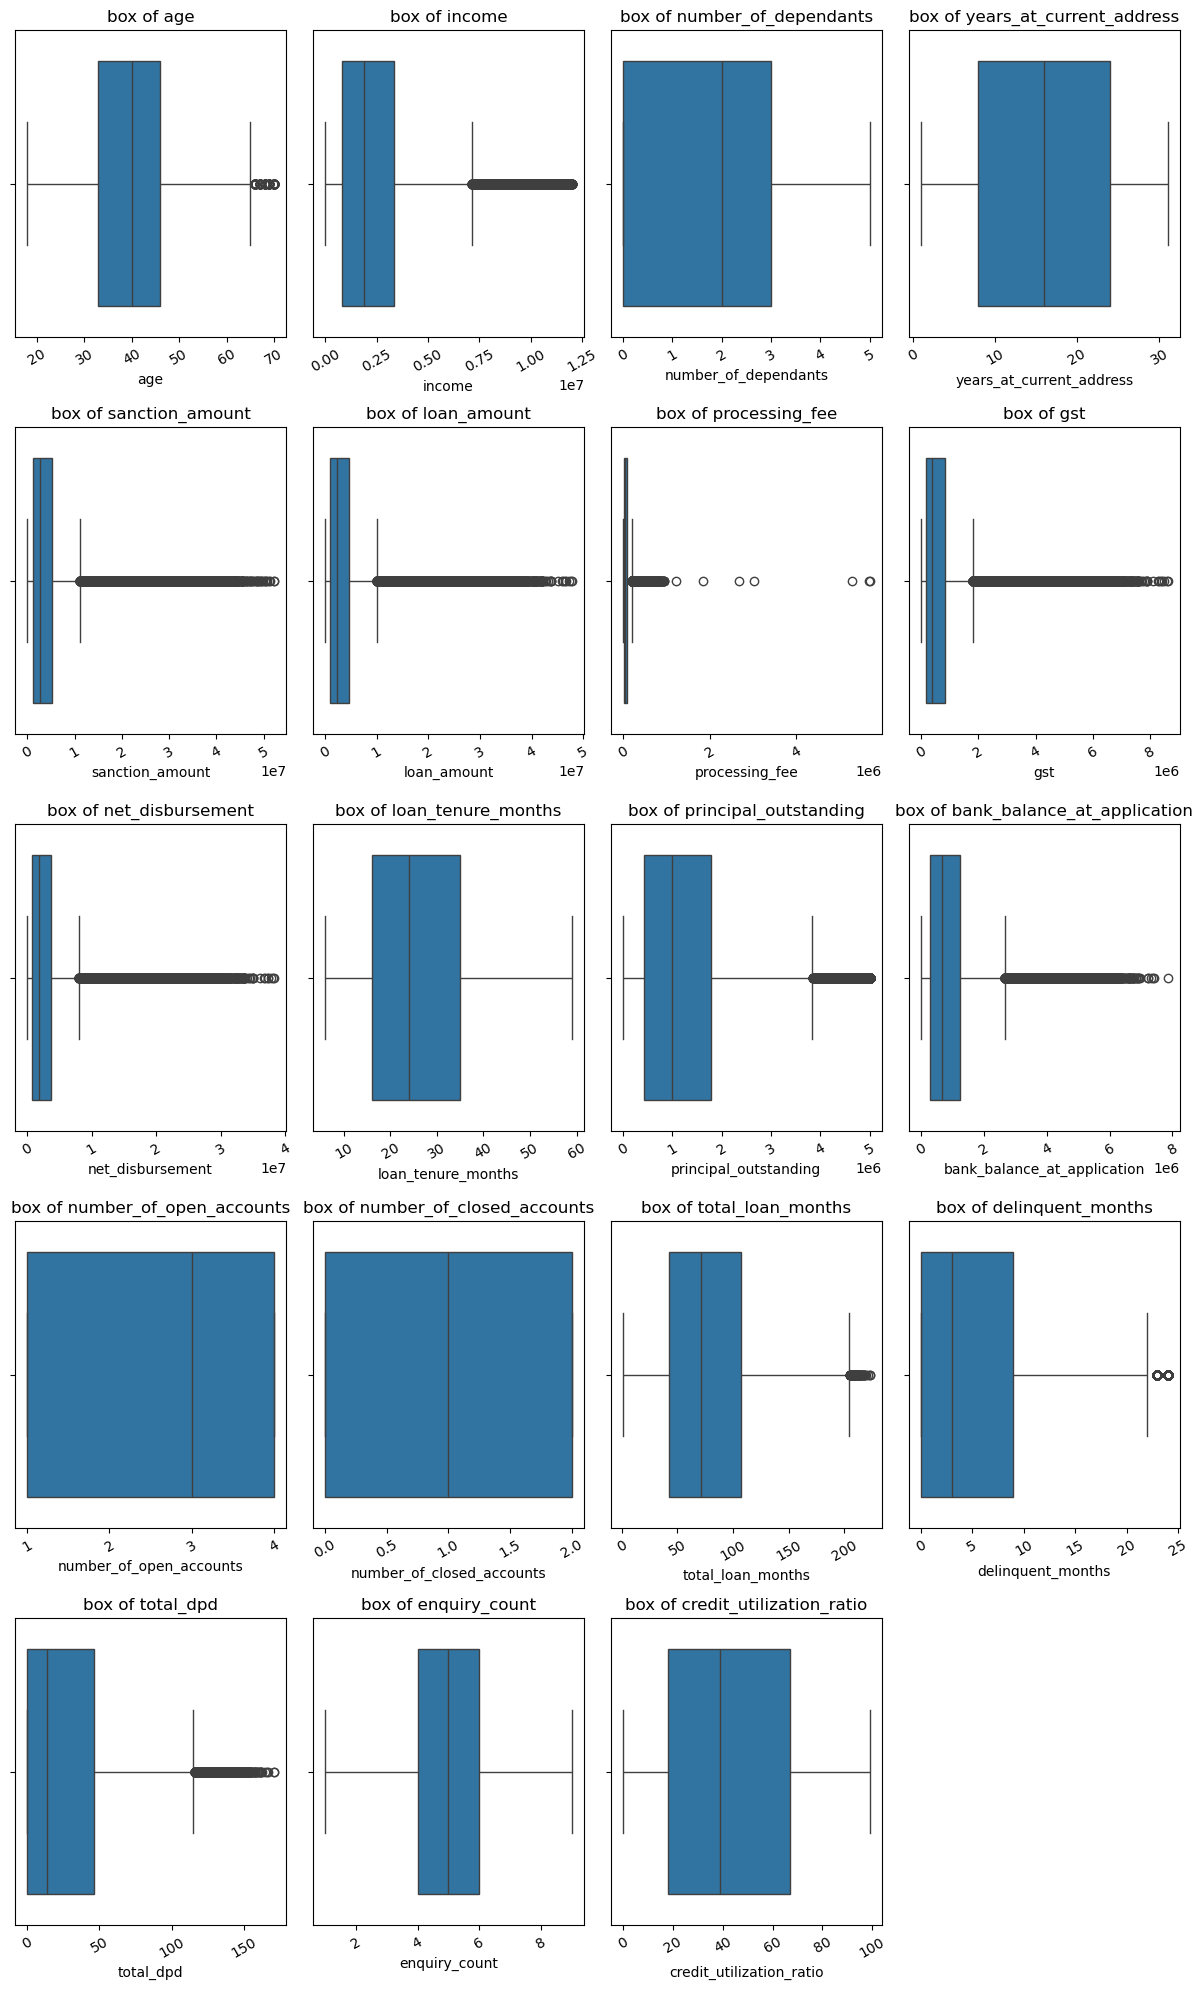

In [15]:
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(12,4*nrows))
axes = axes.flatten()

for i, var in enumerate(num_var):
  sns.boxplot(x=df[var], ax=axes[i])
  axes[i].set_title(f"box of {var}")
  axes[i].tick_params(axis='x', rotation=30)

for j in range(i+1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [16]:
df.shape

(50000, 30)

In [17]:
#Some of the P2L ratio > 1, delete
df['highcharge']=df['processing_fee'] / df['loan_amount']
df[df['highcharge']>1][['processing_fee','loan_amount']]

,processing_fee,loan_amount
9898,5.293544e+06,3626000
12294,5.698030e+06,4639000
23981,2.669791e+06,2234000
28174,1.214493e+06,966000
29305,3.036378e+06,2616000
33705,5.678021e+06,3812000
47089,1.858965e+06,1738000


In [49]:
df['highcharge'].describe()
# count missinig 8 due to loan_amount on demoninator =0

,highcharge
count,49992.000000
mean,0.020174
std,0.014837
min,0.020000
25%,0.020000
50%,0.020000
75%,0.020000
max,1.489512


In [45]:
df1 = df[df['highcharge']<1]
df1 = df1.drop(columns='highcharge')
df1.shape

(49985, 30)

In [23]:
list(df1.columns)

['cust_id',
 'age',
 'gender',
 'marital_status',
 'employment_status',
 'income',
 'number_of_dependants',
 'residence_type',
 'years_at_current_address',
 'loan_id',
 'loan_purpose',
 'loan_type',
 'sanction_amount',
 'loan_amount',
 'processing_fee',
 'gst',
 'net_disbursement',
 'loan_tenure_months',
 'principal_outstanding',
 'bank_balance_at_application',
 'disbursal_date',
 'installment_start_dt',
 'default',
 'number_of_open_accounts',
 'number_of_closed_accounts',
 'total_loan_months',
 'delinquent_months',
 'total_dpd',
 'enquiry_count',
 'credit_utilization_ratio',
 'highcharge']

In [34]:
#直接查看所有的
# for i in num_var:
#     print(i, df.groupby('default')[i].describe())
# for j in char_var:
#     print(j, df.groupby('default')[i].value_counts())

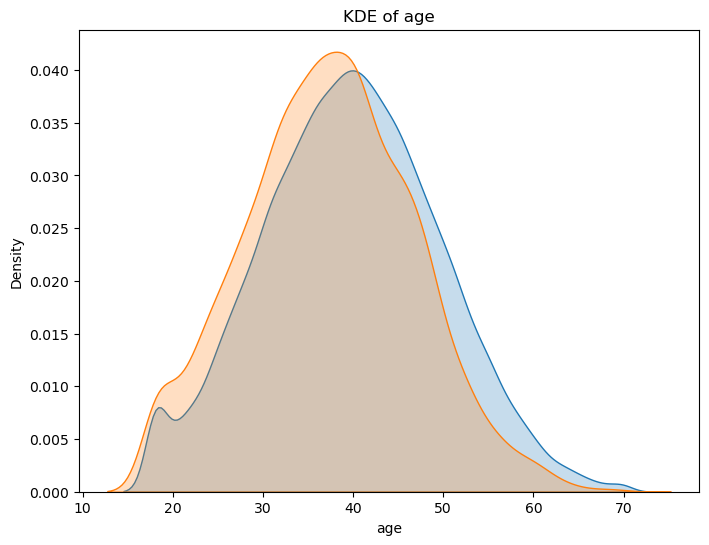

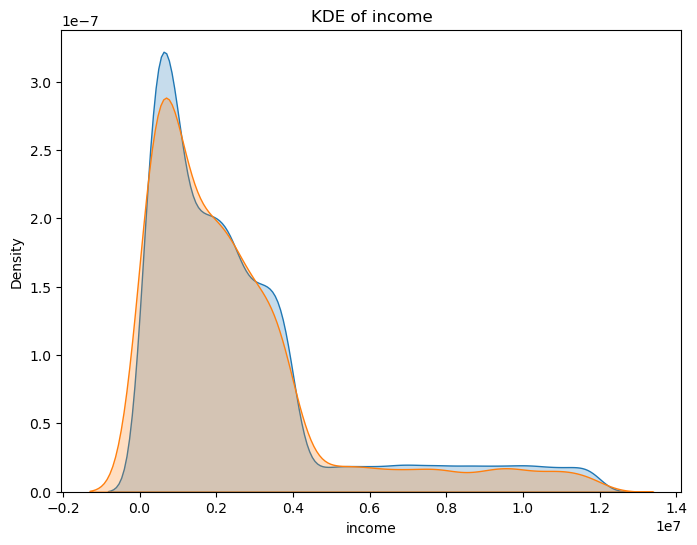

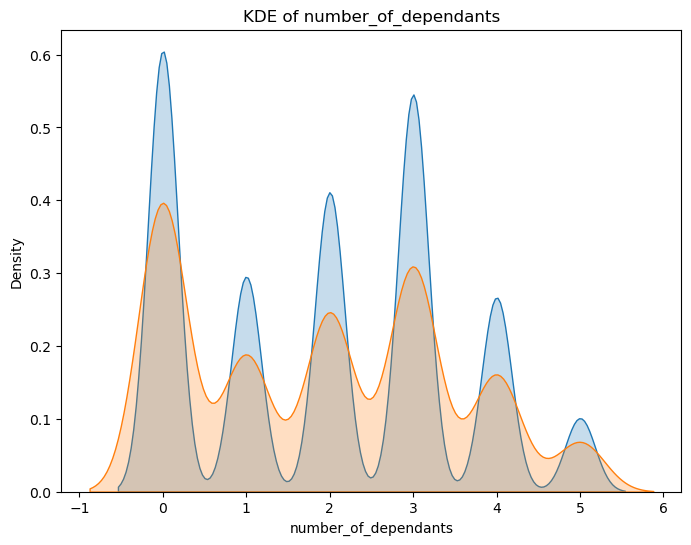

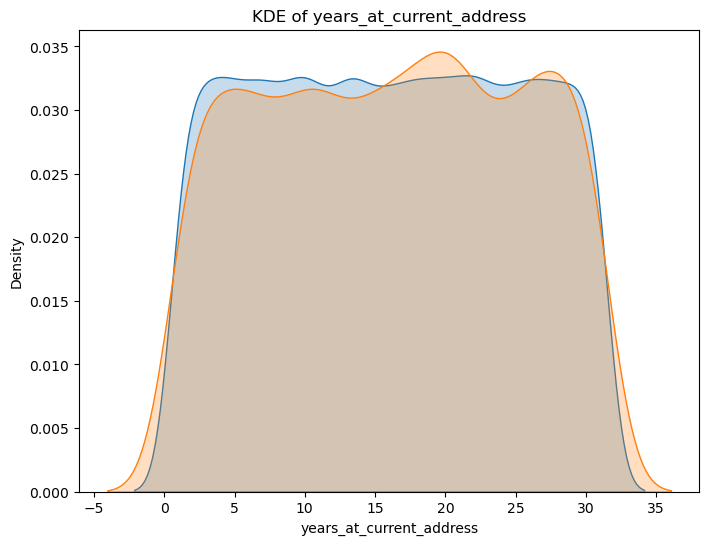

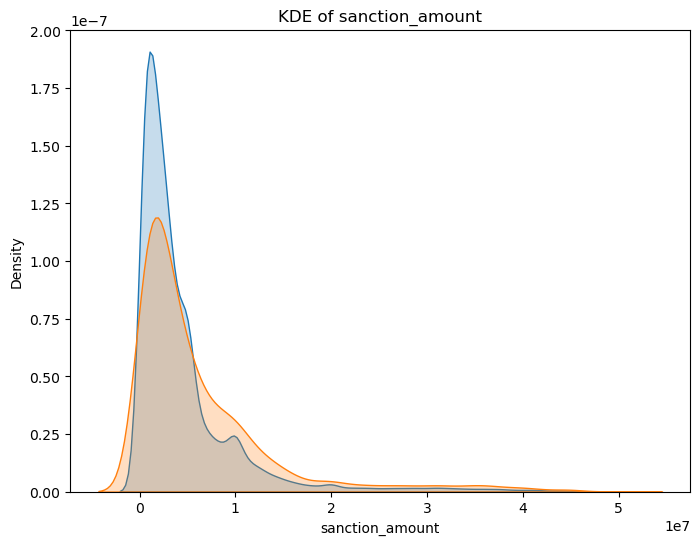

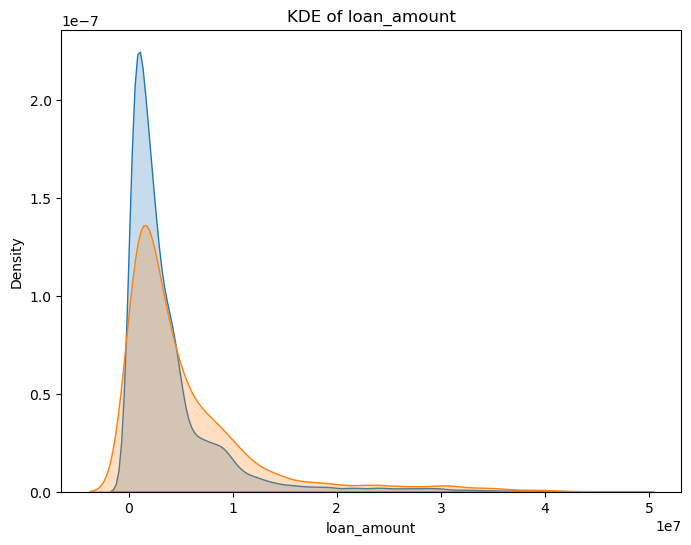

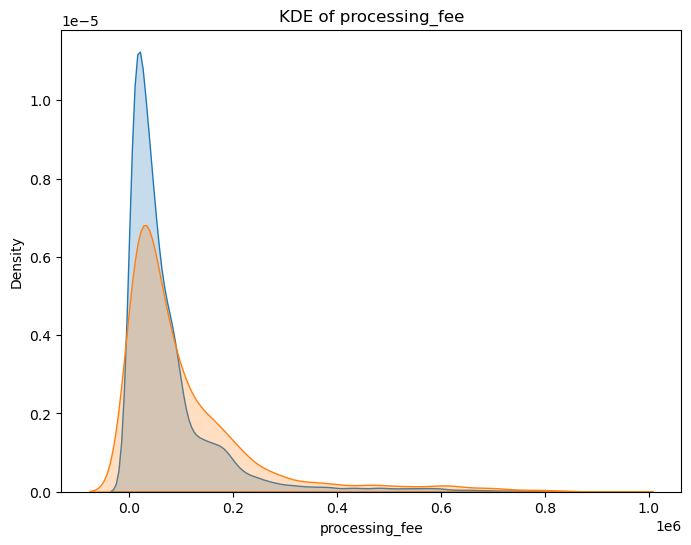

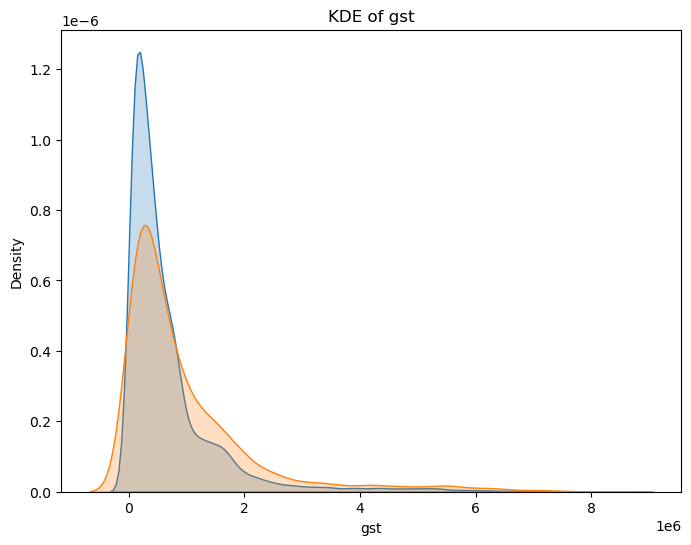

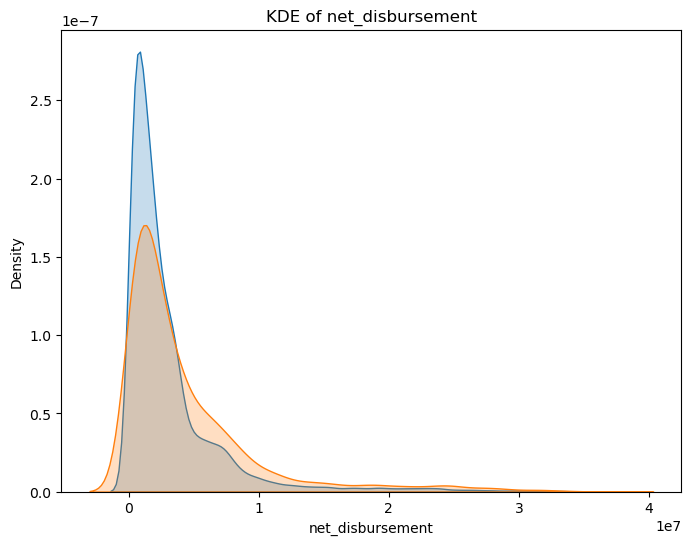

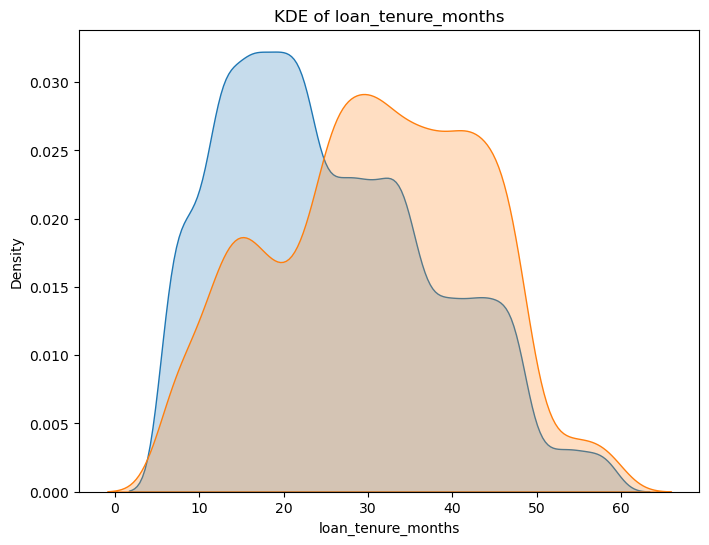

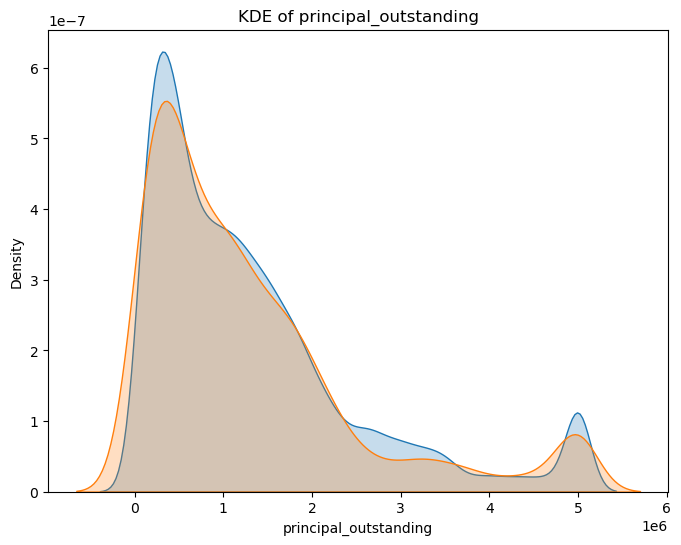

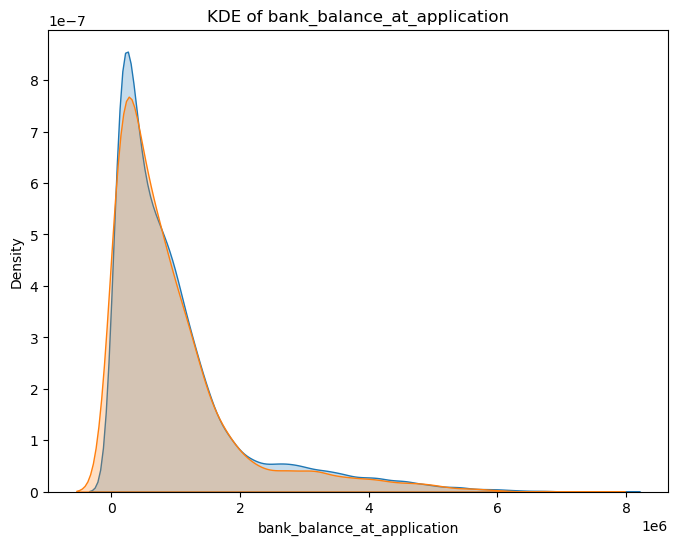

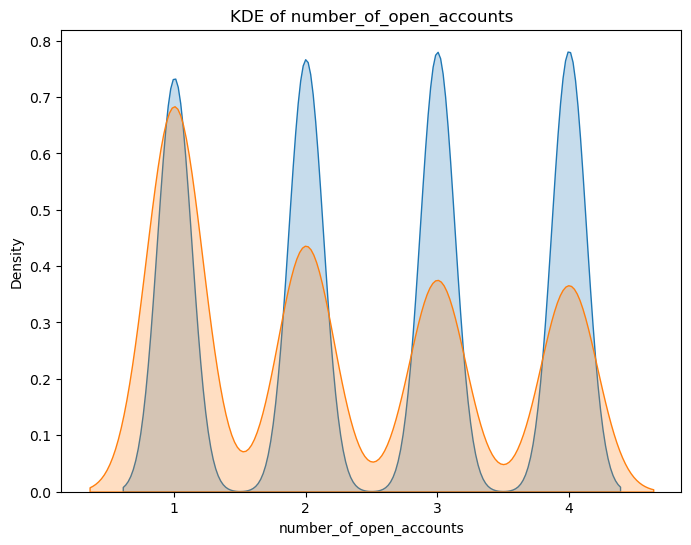

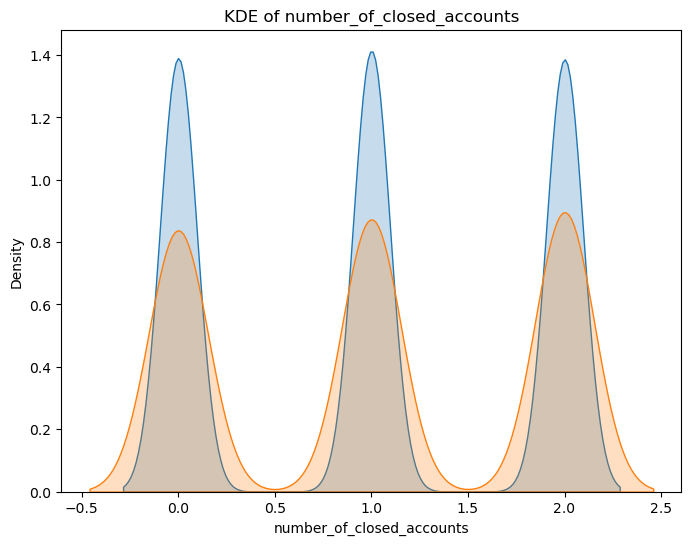

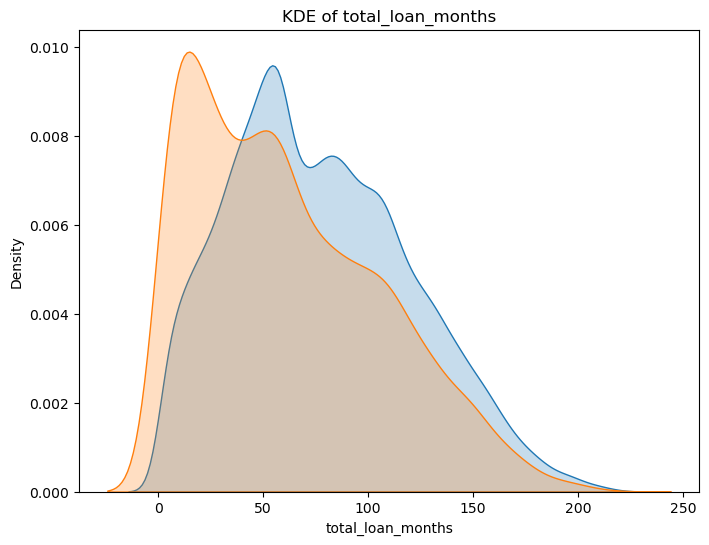

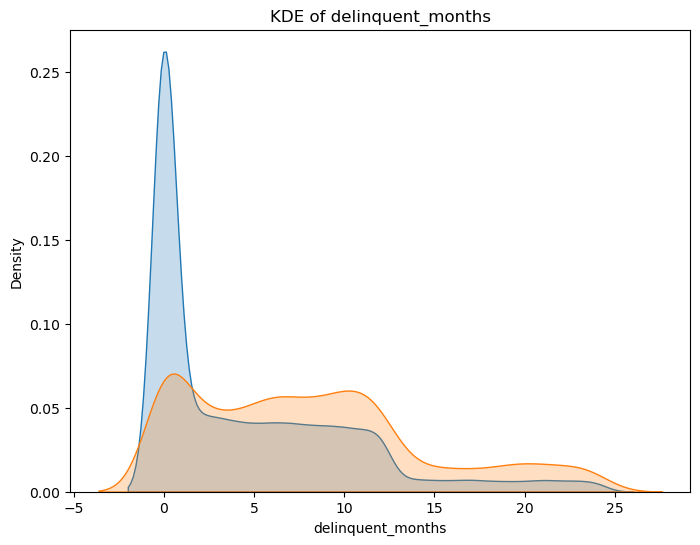

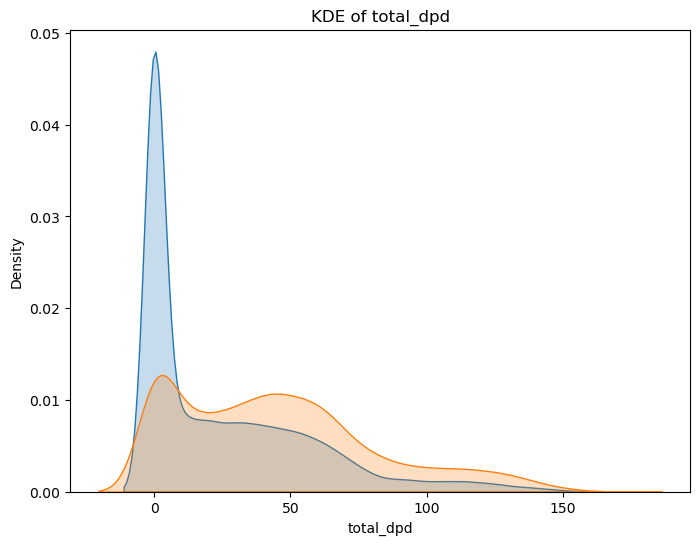

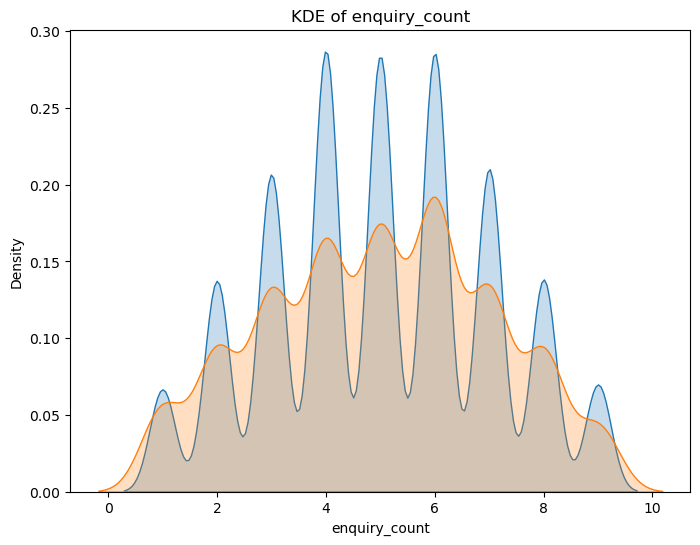

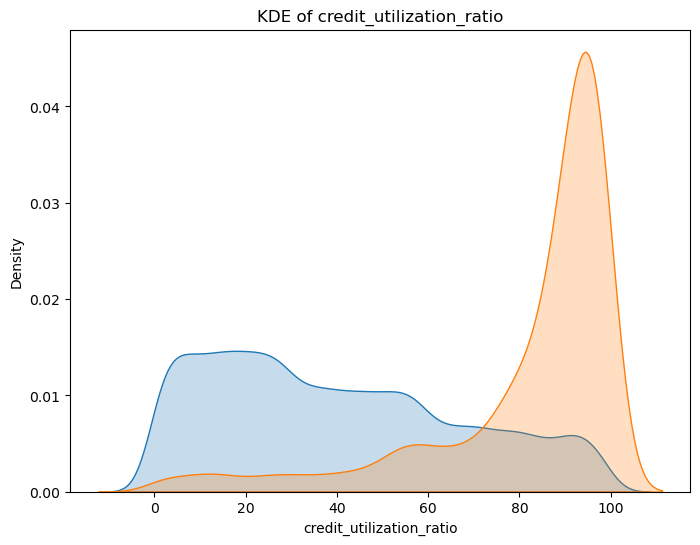

In [60]:
# Lets take a look at each predictor by categorizing by default

# KDE Graphs for all num variables
# for i in num_var:
#     plt.figure(figsize=(8,6))
#     sns.kdeplot(data=df1, x=df[i], hue='default', fill=True)
#     plt.title(f'KDE of {i}')

# Graphs above actually not clear mixing defaulted population together to see the insights, we can separate plot them.
for i in df1.select_dtypes(include=['int64','float64']):
    plt.figure(figsize=(8,6))
    sns.kdeplot(data=df1, x=df1[df1['default']==0][i] , fill=True)
    sns.kdeplot(data=df1, x=df1[df1['default']==1][i] , fill=True)
    plt.title(f'KDE of {i}')


In [ ]:
# Insights:
# 1. high aged population less likelihood of default
# 2. higher loan_tenure_months more likelihood of default
# 3. lower total_loan_month more likelihood of default
# 4. high credit utilization more likelihood of default

<Axes: >

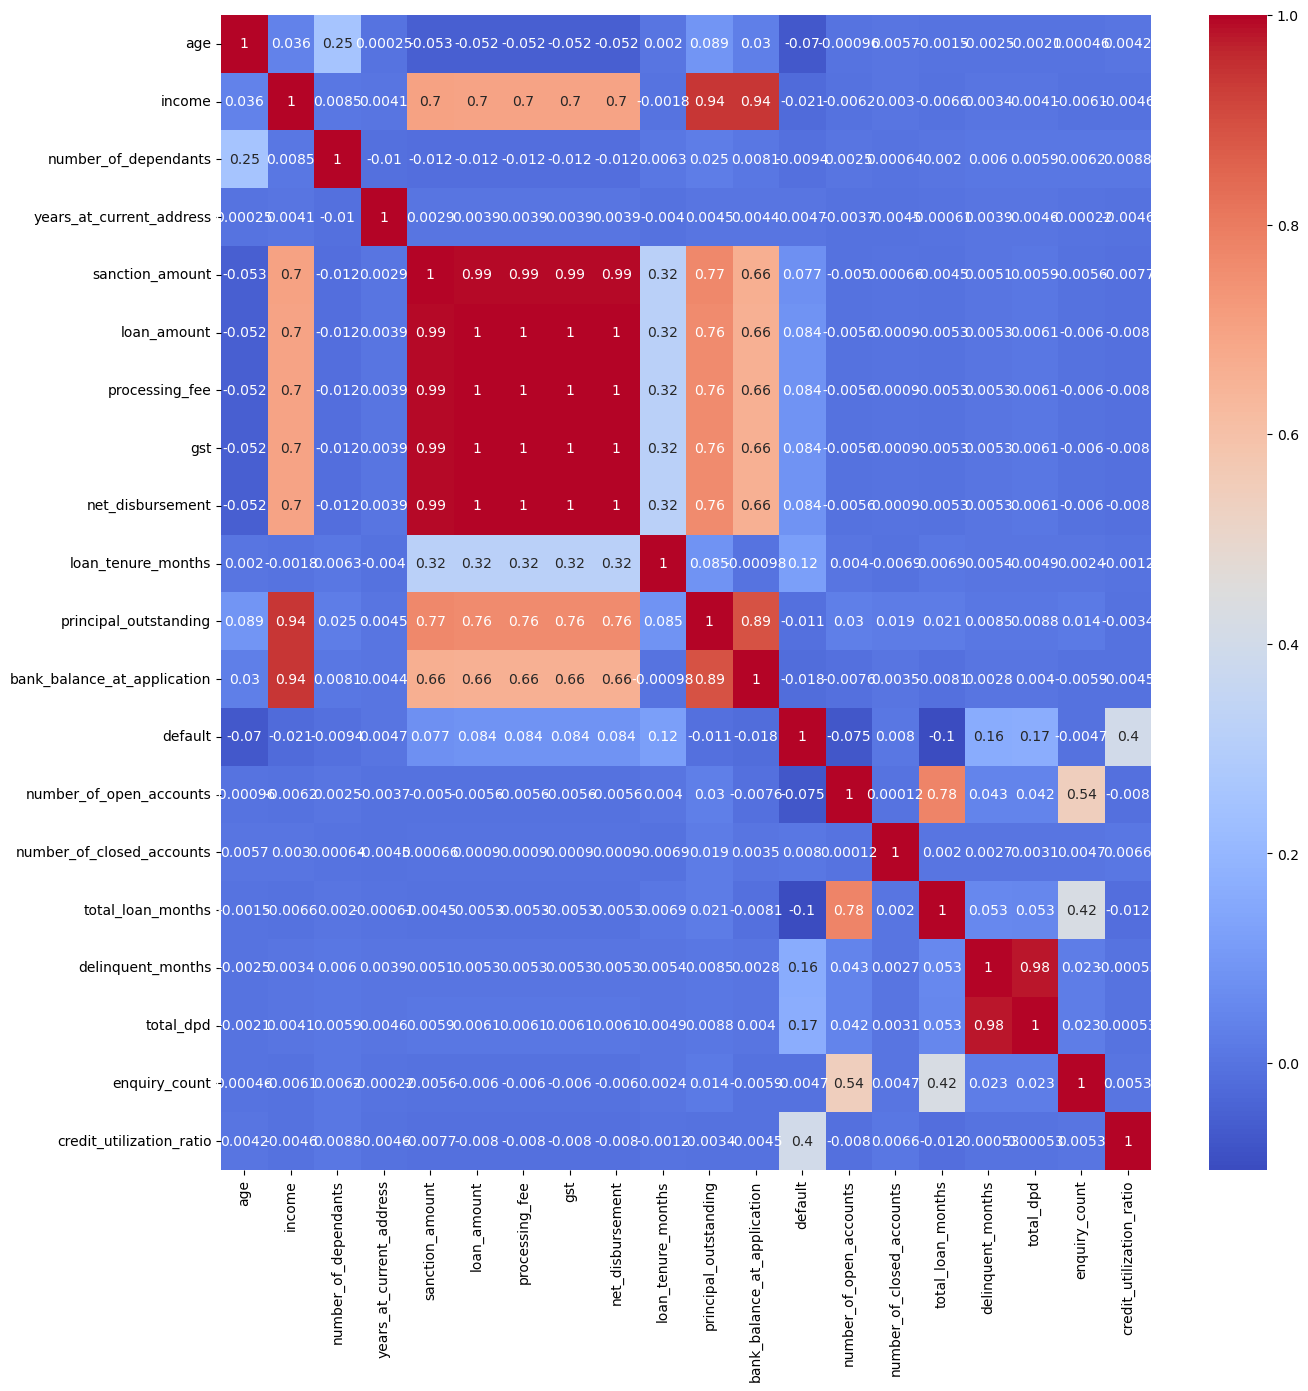

In [68]:
#check correlation of predictors
corr = df1.corr(numeric_only=True)
plt.figure(figsize=(15,15))
sns.heatmap(corr,cmap='coolwarm', annot=True)


<Axes: >

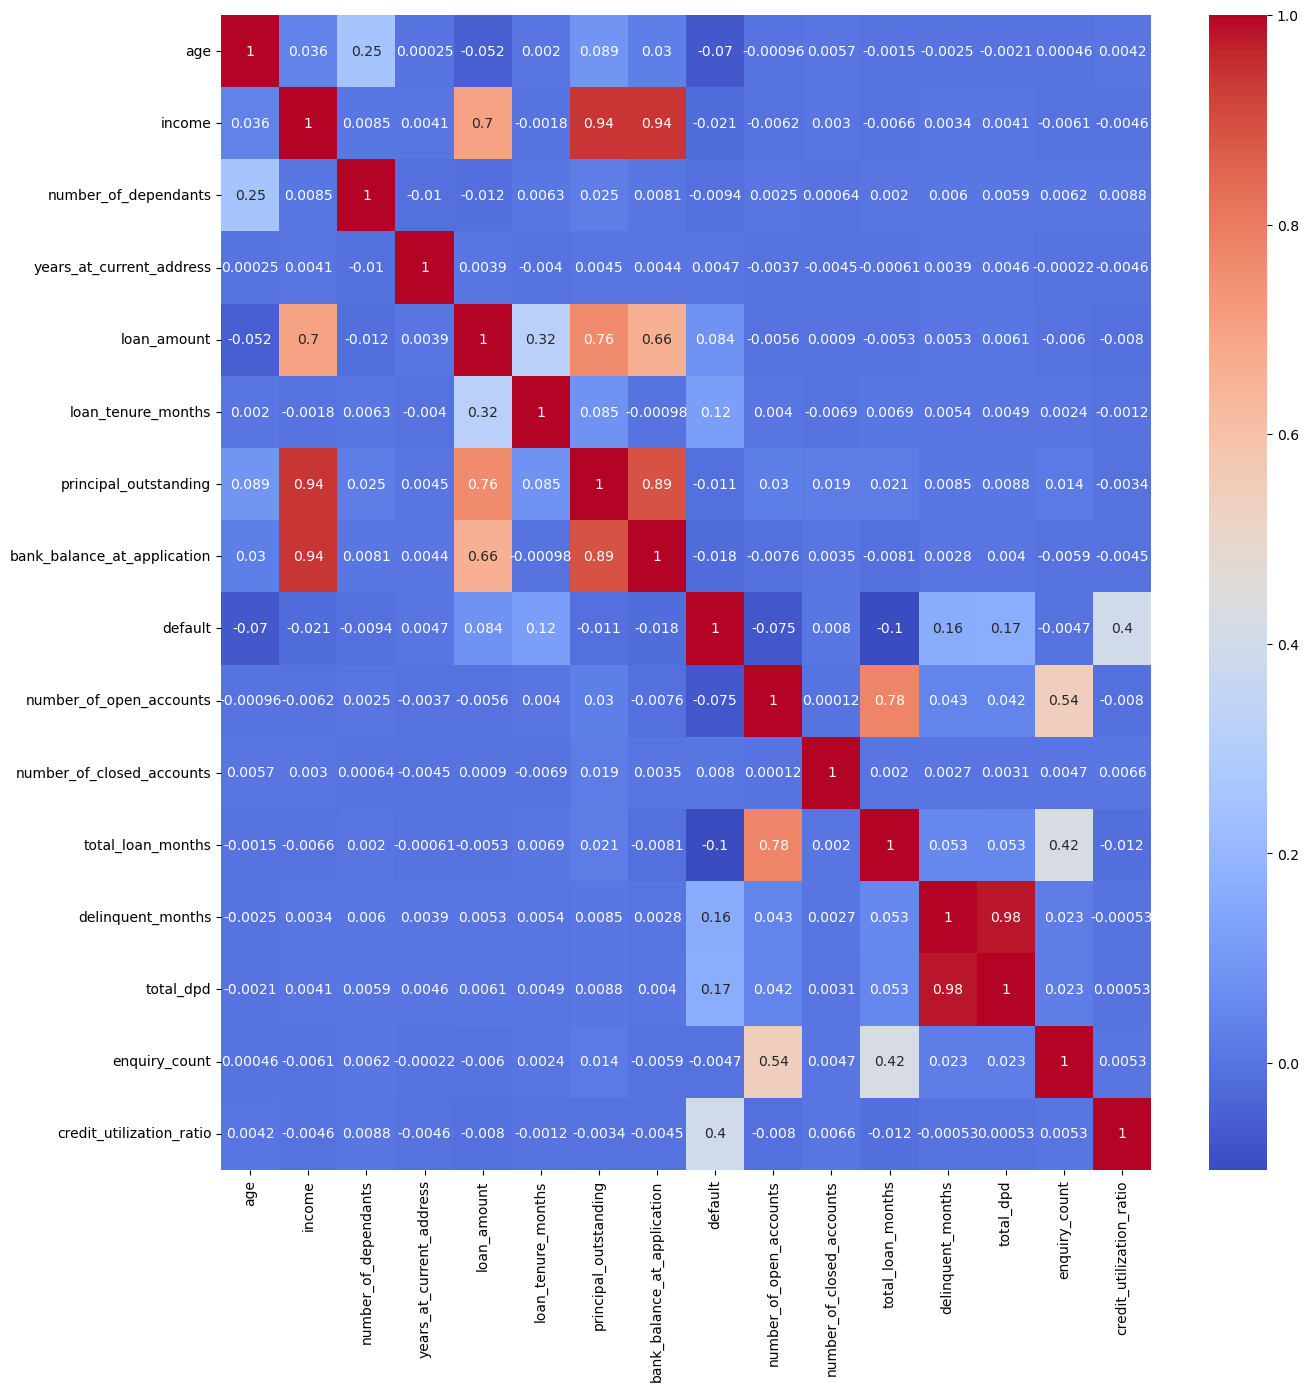

In [71]:
# We need to DROP some columns that apparently multicolinearity with others (Some already have really high correlation)
drop_lst = ['processing_fee', 'sanction_amount', 'gst','net_disbursement']
df2 = df1.drop(columns = drop_lst)
df2.shape
corr = df2.corr(numeric_only=True)
plt.figure(figsize=(15,15))
sns.heatmap(corr,cmap='coolwarm', annot=True)

In [94]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.tools.tools import add_constant
num_var = list(df2.select_dtypes(include='int64'))

X = df2[num_var]
X = add_constant(X)
vif = pd.DataFrame()
vif['feature']=X.columns
vif['VIF']=[VIF(X.values,i) for i in range(X.shape[1])]
vif
# Looks like "delinquent_month" & "total_dpd" high correlated, delete one, leave one "delinquent_month"
# Looks like 'income', 'principal_outstanding', & 'balance_at_application' high correlated, remove 'income', (this is PI, and also not useful for model)
# Some other PI like cust_id and loan_id also need to remove

,feature,VIF
0,const,38.135856
1,age,1.145138
2,income,18.209958
3,number_of_dependants,1.069460
4,years_at_current_address,1.000267
5,loan_amount,2.955438
6,loan_tenure_months,1.251824
7,principal_outstanding,12.226160
8,bank_balance_at_application,9.182828
9,number_of_open_accounts,2.956722


In [96]:
df3 = df2.drop(columns=['income','total_dpd','cust_id','loan_id','disbursal_date','installment_start_dt'])
df3.head()

,age,gender,marital_status,employment_status,number_of_dependants,residence_type,years_at_current_address,loan_purpose,loan_type,loan_amount,loan_tenure_months,principal_outstanding,bank_balance_at_application,default,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,enquiry_count,credit_utilization_ratio
0,44,M,Married,Self-Employed,3,Owned,27,Auto,Secured,2467000,33,1630408,873386,False,1,1,42,0,3,7
1,38,M,Married,Salaried,3,Owned,4,Home,Secured,3883000,30,709309,464100,False,3,1,96,12,5,4
2,46,F,Married,Self-Employed,3,Owned,24,Personal,Unsecured,2170000,21,1562399,1476042,False,2,1,82,24,6,58
3,55,F,Single,Self-Employed,1,Owned,15,Personal,Unsecured,1747000,6,1257839,1031094,False,3,0,115,15,5,26
4,37,M,Married,Salaried,3,Owned,28,Auto,Secured,4520000,28,1772334,1032458,False,4,2,120,0,5,10


In [103]:
df3.groupby('default')['delinquent_months'].describe()

,count,mean,std,min,25%,50%,75%,max
default,,,,,,,,
False,45688.0,4.585033,5.703891,0.0,0.0,2.0,8.0,24.0
True,4297.0,8.001629,6.443512,0.0,3.0,7.0,12.0,24.0


In [ ]:
# Insight:
# at TD, Default defined as:
#         90+ Day Delinquent,
#         Bankruptcy,
#         Balance > 100 ?
# But at dataset, we see delinquent over 3 month also have non-default.

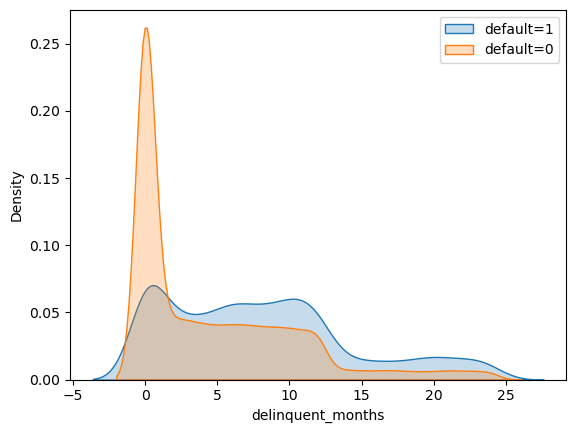

In [102]:
sns.kdeplot(data=df3, x=df3[df3['default']==1]['delinquent_months'],fill=True, label='default=1')
sns.kdeplot(data=df3, x=df3[df3['default']==0]['delinquent_months'],fill=True, label='default=0')
plt.legend()

In [106]:
df3.head(), df3.shape

(   age gender marital_status employment_status  number_of_dependants  \
 0   44      M        Married     Self-Employed                     3   
 1   38      M        Married          Salaried                     3   
 2   46      F        Married     Self-Employed                     3   
 3   55      F         Single     Self-Employed                     1   
 4   37      M        Married          Salaried                     3   
 
   residence_type  years_at_current_address loan_purpose  loan_type  \
 0          Owned                        27         Auto    Secured   
 1          Owned                         4         Home    Secured   
 2          Owned                        24     Personal  Unsecured   
 3          Owned                        15     Personal  Unsecured   
 4          Owned                        28         Auto    Secured   
 
    loan_amount  loan_tenure_months  principal_outstanding  \
 0      2467000                  33                1630408   
 1      

In [ ]:
## Data clean finished, Feature Engineering now, encoded char_var now
